In [3]:
#Importing the basic librarires

import math
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display

#from brokenaxes import brokenaxes
from statsmodels.formula import api
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10,6]

import warnings 
warnings.filterwarnings('ignore')

import os

In [23]:
main_path = os.getcwd().split("/code")[0]

df = pd.read_csv(f"{main_path}/dataset/song_data.csv")

df.drop(['song_name'], axis=1, inplace=True)
display(df.head())

target = 'song_popularity'
features = [i for i in df.columns if i not in [target]]

original_df = df.copy(deep=True)

print('\n\033[1mInference:\033[0m The Datset consists of {} features & {} samples.'.format(df.shape[1], df.shape[0]))

,song_popularity,song_duration_ms,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,audio_mode,speechiness,tempo,time_signature,audio_valence
0,73,262333,0.005520,0.496,0.682,0.000029,8,0.0589,-4.095,1,0.0294,167.060,4,0.474
1,66,216933,0.010300,0.542,0.853,0.000000,3,0.1080,-6.407,0,0.0498,105.256,4,0.370
2,76,231733,0.008170,0.737,0.463,0.447000,0,0.2550,-7.828,1,0.0792,123.881,4,0.324
3,74,216933,0.026400,0.451,0.970,0.003550,0,0.1020,-4.938,1,0.1070,122.444,4,0.198
4,56,223826,0.000954,0.447,0.766,0.000000,10,0.1130,-5.065,1,0.0313,172.011,4,0.574



Inference: The Datset consists of 14 features & 18835 samples.


In [24]:
nu = df[features].nunique().sort_values()
nf = []; cf = []; nnf = 0; ncf = 0; #numerical & categorical features

for i in range(df[features].shape[1]):
    if nu.values[i]<=16:cf.append(nu.index[i])
    else: nf.append(nu.index[i])

print('\n\033[1mInference:\033[0m The Datset has {} numerical & {} categorical features.'.format(len(nf),len(cf)))


Inference: The Datset has 10 numerical & 3 categorical features.


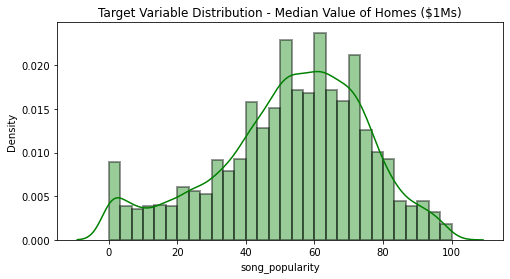

In [6]:
#Let us first analyze the distribution of the target variable

plt.figure(figsize=[8,4])
sns.distplot(df[target], color='g',hist_kws=dict(edgecolor="black", linewidth=2), bins=30)
plt.title('Target Variable Distribution - Median Value of Homes ($1Ms)')
plt.show()

                               Visualising Categorical Features:                                


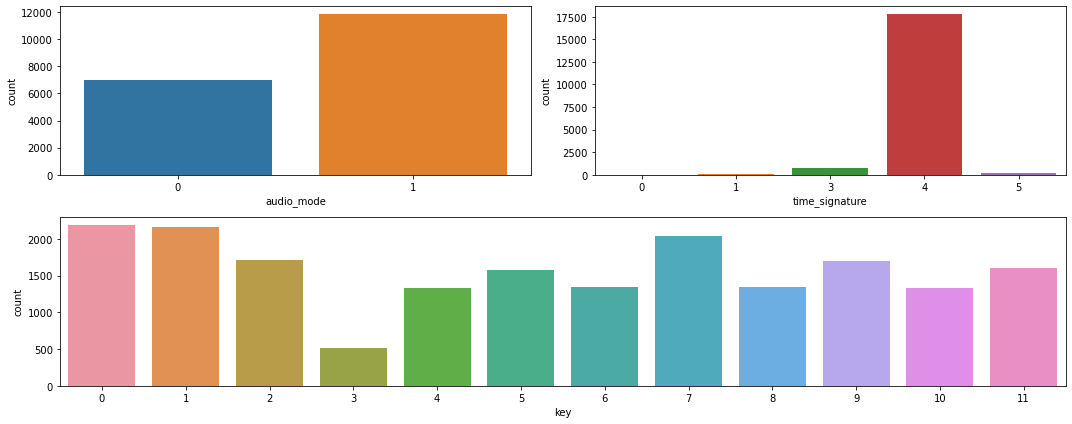

In [7]:
#Visualising the categorical features 

print('\033[1mVisualising Categorical Features:'.center(100))

n=2
plt.figure(figsize=[15,3*math.ceil(len(cf)/n)])

for i in range(len(cf)):
    if df[cf[i]].nunique()<=8:
        plt.subplot(math.ceil(len(cf)/n),n,i+1)
        sns.countplot(df[cf[i]])
    else:
        plt.subplot(2,1,2)
        sns.countplot(df[cf[i]])
        
plt.tight_layout()
plt.show()

                                 Numeric Features Distribution                                  


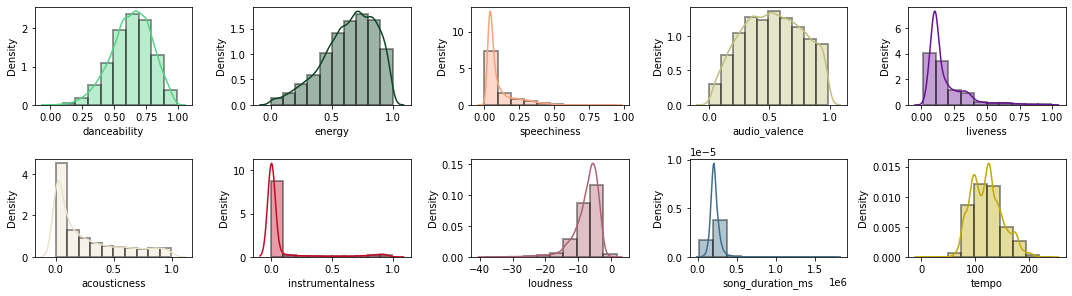

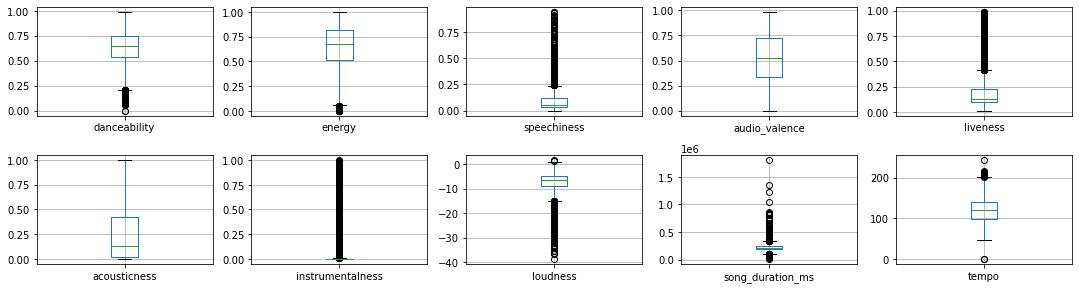

In [8]:
#Visualising the numeric features 

print('\033[1mNumeric Features Distribution'.center(100))

n=5

clr=['r','g','b','g','b','r']

plt.figure(figsize=[15,4*math.ceil(len(nf)/n)])
for i in range(len(nf)):
    plt.subplot(math.ceil(len(nf)/3),n,i+1)
    sns.distplot(df[nf[i]],hist_kws=dict(edgecolor="black", linewidth=2), bins=10, color=list(np.random.randint([255,255,255])/255))
plt.tight_layout()
plt.show()

plt.figure(figsize=[15,4*math.ceil(len(nf)/n)])
for i in range(len(nf)):
    plt.subplot(math.ceil(len(nf)/3),n,i+1)
    df.boxplot(nf[i])
plt.tight_layout()
plt.show()

In [25]:
#Removal of any Duplicate rows (if any)

counter = 0
rs,cs = original_df.shape

df.drop_duplicates(inplace=True)

if df.shape==(rs,cs):
    print('\n\033[1mInference:\033[0m The dataset doesn\'t have any duplicates')
else:
    print(f'\n\033[1mInference:\033[0m Number of duplicates dropped/fixed ---> {rs-df.shape[0]}')


Inference: Number of duplicates dropped/fixed ---> 3911


In [10]:
#Check for empty elements

# nvc = pd.DataFrame(df.isnull().sum().sort_values(), columns=['Total Null Values'])
# nvc['Percentage'] = round(nvc['Total Null Values']/df.shape[0],3)*100
# print(nvc)

                  Total Null Values  Percentage
song_popularity                   0         0.0
song_duration_ms                  0         0.0
acousticness                      0         0.0
danceability                      0         0.0
energy                            0         0.0
instrumentalness                  0         0.0
key                               0         0.0
liveness                          0         0.0
loudness                          0         0.0
audio_mode                        0         0.0
speechiness                       0         0.0
tempo                             0         0.0
time_signature                    0         0.0
audio_valence                     0         0.0


In [26]:
#Converting categorical Columns to Numeric

df3 = df.copy()

# ecc = nvc[nvc['Percentage']!=0].index.values
fcc = [i for i in cf]
#One-Hot Binay Encoding
oh=True
dm=True
for i in fcc:
    #print(i)
    if df3[i].nunique()==2:
        if oh==True: print("\033[1mOne-Hot Encoding on features:\033[0m")
        print(i);oh=False
        df3[i]=pd.get_dummies(df3[i], drop_first=True, prefix=str(i))
    if (df3[i].nunique()>2 and df3[i].nunique()<17):
        if dm==True: print("\n\033[1mDummy Encoding on features:\033[0m")
        print(i);dm=False
        df3 = pd.concat([df3.drop([i], axis=1), pd.DataFrame(pd.get_dummies(df3[i], drop_first=True, prefix=str(i)))],axis=1)
        
df3.shape

One-Hot Encoding on features:
audio_mode

Dummy Encoding on features:
time_signature
key


(14924, 27)

In [27]:
nf

['danceability',
 'energy',
 'speechiness',
 'audio_valence',
 'liveness',
 'acousticness',
 'instrumentalness',
 'loudness',
 'song_duration_ms',
 'tempo']

In [33]:
#Removal of outlier:

df1 = df3.copy()

#features1 = [i for i in features if i not in ['CHAS','RAD']]
features1 = nf

for i in features1:
    Q1 = df1[i].quantile(0.25)
    Q3 = df1[i].quantile(0.75)
    IQR = Q3 - Q1
    df1 = df1[df1[i] <= (Q3+(1.5*IQR))]
    df1 = df1[df1[i] >= (Q1-(1.5*IQR))]
    df1 = df1.reset_index(drop=True)
display(df1.tail())
print('\n\033[1mInference:\033[0m\nBefore removal of outliers, The dataset had {} samples.'.format(df3.shape[0]))
print('After removal of outliers, The dataset now has {} samples.'.format(df1.shape[0]))
df1.shape

,song_popularity,song_duration_ms,acousticness,danceability,energy,instrumentalness,liveness,loudness,audio_mode,speechiness,...,key_2,key_3,key_4,key_5,key_6,key_7,key_8,key_9,key_10,key_11
8945,55,114582,0.898,0.370,0.136,0.000263,0.0999,-13.528,1,0.0433,...,0,0,0,0,0,1,0,0,0,0
8946,62,195106,0.395,0.644,0.523,0.000000,0.0930,-7.660,1,0.0378,...,0,0,1,0,0,0,0,0,0,0
8947,60,205666,0.765,0.495,0.161,0.000001,0.1050,-14.078,0,0.0301,...,0,0,0,0,0,0,0,0,0,1
8948,23,182211,0.847,0.719,0.325,0.000000,0.1250,-12.222,1,0.0355,...,0,0,0,0,0,0,0,0,0,0
8949,60,193533,0.911,0.640,0.381,0.000254,0.1040,-11.790,1,0.0302,...,0,0,1,0,0,0,0,0,0,0



Inference:
Before removal of outliers, The dataset had 14924 samples.
After removal of outliers, The dataset now has 8950 samples.


(8950, 27)

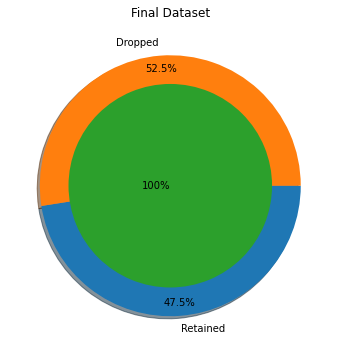


Inference: After the cleanup process, 9885 samples were dropped, while retaining 52.48% of the data.


In [34]:
#Final Dataset size after performing Preprocessing

df = df1.copy()
df.columns=[i.replace('-','_') for i in df.columns]

plt.title('Final Dataset')
plt.pie([df.shape[0], original_df.shape[0]-df.shape[0]], radius = 1, labels=['Retained','Dropped'], counterclock=False, 
        autopct='%1.1f%%', pctdistance=0.9, explode=[0,0], shadow=True)
plt.pie([df.shape[0]], labels=['100%'], labeldistance=-0, radius=0.78)
plt.show()

print(f'\n\033[1mInference:\033[0m After the cleanup process, {original_df.shape[0]-df.shape[0]} samples were dropped, \
while retaining {round(100 - (df.shape[0]*100/(original_df.shape[0])),2)}% of the data.')

In [35]:
#Splitting the data intro training & testing sets

m=[]
for i in df.columns.values:
    m.append(i.replace(' ','_'))
    
df.columns = m
X = df.drop([target],axis=1)
Y = df[target]
Train_X, Test_X, Train_Y, Test_Y = train_test_split(X, Y, train_size=0.8, test_size=0.2, random_state=100)
Train_X.reset_index(drop=True,inplace=True)

print('Original set  ---> ',X.shape,Y.shape,'\nTraining set  ---> ',Train_X.shape,Train_Y.shape,'\nTesting set   ---> ', Test_X.shape,'', Test_Y.shape)

Original set  --->  (8950, 26) (8950,) 
Training set  --->  (7160, 26) (7160,) 
Testing set   --->  (1790, 26)  (1790,)


In [36]:
#Feature Scaling (Standardization)

std = StandardScaler()

print('\033[1mStandardardization on Training set'.center(120))
Train_X_std = std.fit_transform(Train_X)
Train_X_std = pd.DataFrame(Train_X_std, columns=X.columns)
display(Train_X_std.describe())

print('\n','\033[1mStandardardization on Testing set'.center(120))
Test_X_std = std.transform(Test_X)
Test_X_std = pd.DataFrame(Test_X_std, columns=X.columns)
display(Test_X_std.describe())

                                         Standardardization on Training set                                         


,song_duration_ms,acousticness,danceability,energy,instrumentalness,liveness,loudness,audio_mode,speechiness,tempo,...,key_2,key_3,key_4,key_5,key_6,key_7,key_8,key_9,key_10,key_11
count,7.160000e+03,7.160000e+03,7.160000e+03,7.160000e+03,7.160000e+03,7.160000e+03,7.160000e+03,7.160000e+03,7.160000e+03,7.160000e+03,...,7.160000e+03,7.160000e+03,7.160000e+03,7.160000e+03,7.160000e+03,7.160000e+03,7.160000e+03,7.160000e+03,7.160000e+03,7.160000e+03
mean,-2.201839e-16,-9.368670e-17,-4.790860e-16,-1.105261e-16,2.271148e-16,-6.931141e-18,-1.079676e-16,-4.141008e-16,1.498336e-16,-1.500972e-16,...,2.755245e-16,-3.994710e-16,-2.493350e-16,-1.058573e-15,2.239828e-16,8.855889e-16,3.041174e-16,4.315294e-17,2.786102e-16,1.325910e-16
std,1.000070e+00,1.000070e+00,1.000070e+00,1.000070e+00,1.000070e+00,1.000070e+00,1.000070e+00,1.000070e+00,1.000070e+00,1.000070e+00,...,1.000070e+00,1.000070e+00,1.000070e+00,1.000070e+00,1.000070e+00,1.000070e+00,1.000070e+00,1.000070e+00,1.000070e+00,1.000070e+00
min,-2.625387e+00,-9.181177e-01,-2.918774e+00,-3.131156e+00,-3.425841e-01,-1.575563e+00,-2.825473e+00,-1.348254e+00,-9.812680e-01,-2.528553e+00,...,-3.215677e-01,-1.695159e-01,-2.772249e-01,-3.073541e-01,-2.801351e-01,-3.603778e-01,-2.824479e-01,-3.239418e-01,-2.671612e-01,-2.974504e-01
25%,-6.702830e-01,-8.223387e-01,-6.452384e-01,-6.864460e-01,-3.425841e-01,-6.881147e-01,-5.876500e-01,-1.348254e+00,-6.975836e-01,-7.615380e-01,...,-3.215677e-01,-1.695159e-01,-2.772249e-01,-3.073541e-01,-2.801351e-01,-3.603778e-01,-2.824479e-01,-3.239418e-01,-2.671612e-01,-2.974504e-01
50%,-6.177447e-02,-4.150227e-01,5.798743e-02,1.271097e-01,-3.411082e-01,-3.751120e-01,1.864114e-01,7.417001e-01,-4.002151e-01,-1.426259e-02,...,-3.215677e-01,-1.695159e-01,-2.772249e-01,-3.073541e-01,-2.801351e-01,-3.603778e-01,-2.824479e-01,-3.239418e-01,-2.671612e-01,-2.974504e-01
75%,6.146981e-01,5.921024e-01,7.219555e-01,8.042306e-01,-2.673929e-01,4.767485e-01,7.447833e-01,7.417001e-01,2.966273e-01,6.418977e-01,...,-3.215677e-01,-1.695159e-01,-2.772249e-01,-3.073541e-01,-2.801351e-01,-3.603778e-01,-2.824479e-01,-3.239418e-01,-2.671612e-01,-2.974504e-01
max,2.716562e+00,2.672887e+00,2.386143e+00,1.703690e+00,6.650948e+00,2.864200e+00,2.376364e+00,7.417001e-01,3.368207e+00,2.773299e+00,...,3.109765e+00,5.899152e+00,3.607179e+00,3.253577e+00,3.569706e+00,2.774865e+00,3.540476e+00,3.086975e+00,3.743058e+00,3.361905e+00



                                          Standardardization on Testing set                                          


,song_duration_ms,acousticness,danceability,energy,instrumentalness,liveness,loudness,audio_mode,speechiness,tempo,...,key_2,key_3,key_4,key_5,key_6,key_7,key_8,key_9,key_10,key_11
count,1790.000000,1790.000000,1790.000000,1790.000000,1790.000000,1790.000000,1790.000000,1790.000000,1790.000000,1790.000000,...,1790.000000,1790.000000,1790.000000,1790.000000,1790.000000,1790.000000,1790.000000,1790.000000,1790.000000,1790.000000
mean,0.036125,-0.014032,0.006938,0.028758,0.010602,-0.058353,0.026948,0.009632,-0.023773,-0.005688,...,-0.012939,0.006781,-0.001628,0.024867,-0.058608,-0.015326,0.025095,0.036205,-0.022964,-0.003066
std,0.971755,0.975985,0.990170,0.974326,1.002490,0.982153,0.979911,0.997307,0.968979,1.002542,...,0.981985,1.019502,0.997564,1.035975,0.896783,0.981478,1.040064,1.048494,0.959254,0.995564
min,-2.491247,-0.918115,-2.932429,-2.934083,-0.342584,-1.543058,-2.781757,-1.348254,-0.972847,-2.236695,...,-0.321568,-0.169516,-0.277225,-0.307354,-0.280135,-0.360378,-0.282448,-0.323942,-0.267161,-0.297450
25%,-0.613785,-0.815321,-0.624756,-0.610649,-0.342584,-0.734631,-0.562450,-1.348254,-0.703373,-0.755222,...,-0.321568,-0.169516,-0.277225,-0.307354,-0.280135,-0.360378,-0.282448,-0.323942,-0.267161,-0.297450
50%,-0.024516,-0.425960,0.064815,0.149849,-0.341076,-0.425551,0.223624,0.741700,-0.412847,-0.021330,...,-0.321568,-0.169516,-0.277225,-0.307354,-0.280135,-0.360378,-0.282448,-0.323942,-0.267161,-0.297450
75%,0.611647,0.586634,0.733904,0.809284,-0.262995,0.373068,0.727351,0.741700,0.323469,0.580851,...,-0.321568,-0.169516,-0.277225,-0.307354,-0.280135,-0.360378,-0.282448,-0.323942,-0.267161,-0.297450
max,2.685640,2.669241,2.345178,1.693583,6.608043,2.852991,2.786427,0.741700,3.368207,2.675691,...,3.109765,5.899152,3.607179,3.253577,3.569706,2.774865,3.540476,3.086975,3.743058,3.361905


                                       Correlation Matrix                                       


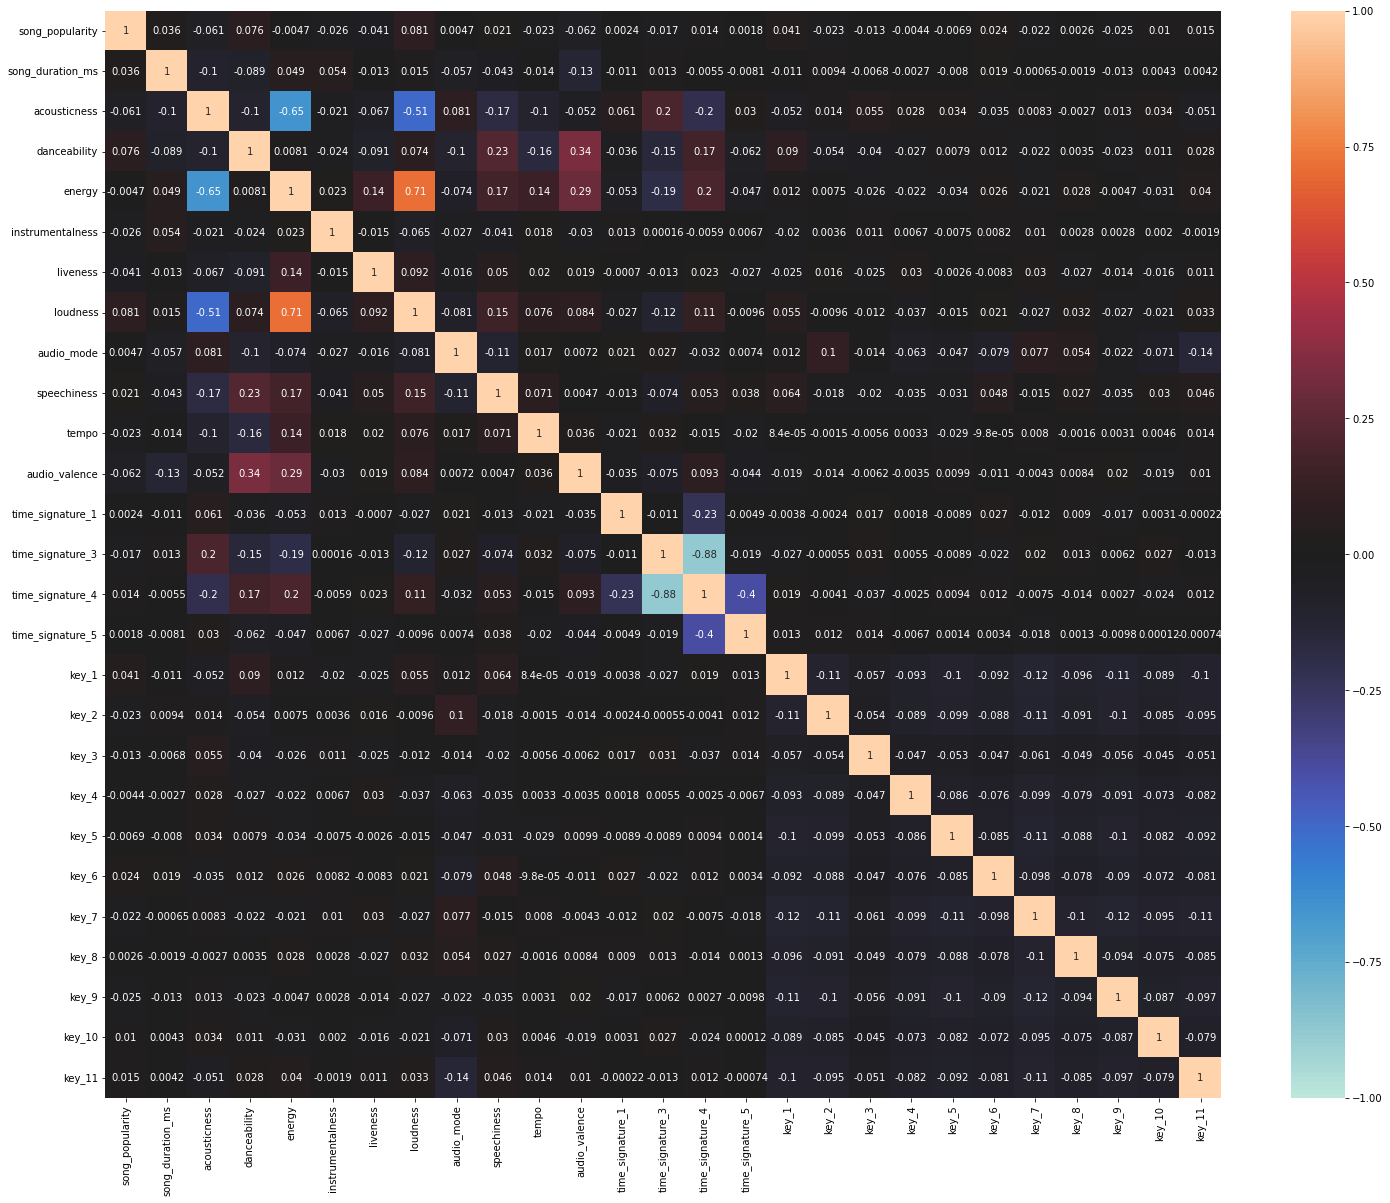

In [37]:
print('\033[1mCorrelation Matrix'.center(100))
plt.figure(figsize=[25,20])
sns.heatmap(df.corr(), annot=True, vmin=-1, vmax=1, center=0) #cmap='BuGn'
plt.show()

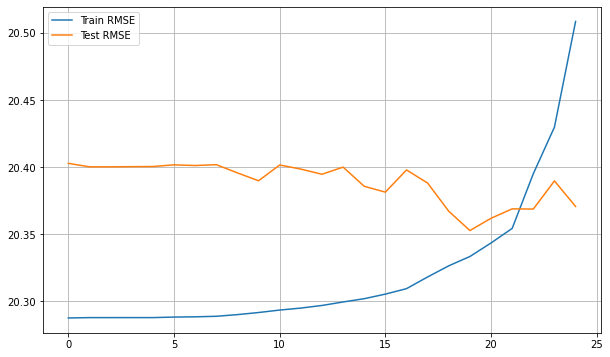

In [38]:
from sklearn.preprocessing import PolynomialFeatures
Trr=[]; Tss=[]; n=3
order=['ord-'+str(i) for i in range(2,n)]
Trd = pd.DataFrame(np.zeros((10,n-2)), columns=order)
Tsd = pd.DataFrame(np.zeros((10,n-2)), columns=order)

m=df.shape[1]-2
for i in range(m):
    lm = LinearRegression()
    rfe = RFE(lm,n_features_to_select=Train_X_std.shape[1]-i)             # running RFE
    rfe = rfe.fit(Train_X_std, Train_Y)

    LR = LinearRegression()
    LR.fit(Train_X_std.loc[:,rfe.support_], Train_Y)

    pred1 = LR.predict(Train_X_std.loc[:,rfe.support_])
    pred2 = LR.predict(Test_X_std.loc[:,rfe.support_])

    Trr.append(np.sqrt(mean_squared_error(Train_Y, pred1)))
    Tss.append(np.sqrt(mean_squared_error(Test_Y, pred2)))

# plt.figure(figsize=[20,4])
# plt.subplot(1,3,1)
# sns.heatmap(Trd.loc[:6], cmap='BuGn', annot=True, vmin=0, vmax=Trd.max().max())
# plt.title('Train RMSE')
# plt.subplot(1,3,2)
# sns.heatmap(Tsd.loc[:6], cmap='BuGn', annot=True, vmin=0, vmax=Trd.max().max()+10)
# plt.title('Test RMSE')
# plt.subplot(1,3,3)
# sns.heatmap((Trd+Tsd).loc[:6], cmap='BuGn', annot=True, vmin=0, vmax=Trd.max().max()+25)
# plt.title('Total RMSE')
# plt.show()

plt.plot(Trr, label='Train RMSE')
plt.plot(Tss, label='Test RMSE')
#plt.ylim([19.75,20.75])
plt.legend()
plt.grid()
plt.show()

In [8]:
from sklearn.datasets import load_iris
import pandas as pd

In [28]:
dict_iris = load_iris()
data = dict_iris["data"]
target = dict_iris["target"]
columns_names = [v.replace(" (cm)", "").replace(" ", "_") for v in dict_iris["feature_names"]]

In [31]:
df = pd.DataFrame(data, columns=columns_names)

In [51]:
from sklearn.linear_model import LogisticRegressionCV
clf_1 = LogisticRegression(C=1.0, class_weight={0:100,1:0.2}, dual=False, fit_intercept=True,
                  intercept_scaling=1, l1_ratio=None, max_iter=100,
                  multi_class='auto', n_jobs=None, penalty='l2',
                  random_state=None, solver='lbfgs', tol=0.0001,       verbose=0,
                  warm_start=False)

In [ ]:
from sklearn.linear_model import Logistic

In [35]:
from sklearn.model_selection import train_test_split

In [52]:
X_Train, X_Test, Y_Train, Y_Test = train_test_split(df, target, test_size=0.3, random_state=42)

In [53]:
clf_1.fit(X_Train, Y_Train)

LogisticRegression(class_weight={0: 100, 1: 0.2})

In [54]:
y_pred = clf_1.predict(X_Test)
y_pred_train = clf_1.predict(X_Train)

In [55]:
from sklearn.metrics import confusion_matrix

In [56]:
conf_mat = confusion_matrix(Y_Test, y_pred)
conf_mat_t = confusion_matrix(Y_Train, y_pred_train)

In [57]:
import matplotlib.pyplot as plt
import seaborn as sns

<AxesSubplot:>

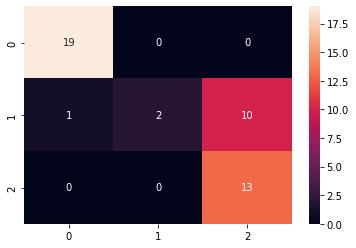

In [58]:
sns.heatmap(conf_mat, annot=True, )

<AxesSubplot:>

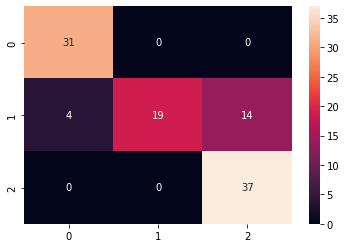

In [50]:
sns.heatmap(conf_mat_t, annot=True)

In [59]:
from sklearn.metrics import accuracy_score

In [61]:
print(f"{accuracy_score(Y_Train, y_pred_train)}")

0.8285714285714286


In [62]:
print(f"{accuracy_score(Y_Test, y_pred)}")

0.7555555555555555


In [29]:
class DrugAnalyzer:
    # TODO: Part 1 - Add method(s) necessary to fulfill the requirements.
    def __init__(self, m_list):
        self.data = m_list
        
    def __add__(self, m_list):
        
        if isinstance(m_list, list):
            self.data.append(m_list)
            return DrugAnalyzer(self.data)
        else:
            raise ValueError("List value is required")
    
    def verify_series(
        self,
        series_id: str,
        act_subst_wgt: float,
        act_subst_rate: float,
        allowed_imp: float,
    ) -> bool:
        # TODO: Part 2 - Implement this method.
        return True

In [30]:
analyzer = DrugAnalyzer([["L01-10", 1007.67, 102.88, 1.00100], ["L01-06", 996.42, 99.68, 2.00087]])

In [31]:
analyzer.data

[['L01-10', 1007.67, 102.88, 1.001], ['L01-06', 996.42, 99.68, 2.00087]]

In [32]:
new_analyzer = analyzer + ["L01-13", 987.63, 101.88, 1.34100]

In [33]:
new_analyzer.data

[['L01-10', 1007.67, 102.88, 1.001],
 ['L01-06', 996.42, 99.68, 2.00087],
 ['L01-13', 987.63, 101.88, 1.341]]

In [34]:
data = [["L01-10", 1007.67, 102.88, 1.00100], ["L01-06", 996.42, 99.68, 2.00087]]

In [38]:
class DrugAnalyzer:
    # TODO: Part 1 - Add method(s) necessary to fulfill the requirements.
    def __init__(self, m_list):
        self.data = m_list

    def __add__(self, m_list):
        
        if len(m_list) == len(self.data[0]):
            if isinstance(m_list, list):
                if isinstance(m_list[0], str) and isinstance(m_list[1], float) and isinstance(m_list[2], float) and isinstance(m_list[3], float):
                    self.data.append(m_list)
                    
                    return DrugAnalyzer(self.data)
                else:
                    raise ValueError("Value type error")
            else:
                raise ValueError("list value type error")                    
        else:
            raise ValueError("Improper length of the added list")
    
    def verify_series(
        self,
        series_id: str,
        act_subst_wgt: float,
        act_subst_rate: float,
        allowed_imp: float,
    ) -> bool:
        # TODO: Part 2 - Implement this method.
        w = 0
        act_w = 0
        pill_w = 0
        imp_sum = 0
        act_weight = 0
        
        for v in self.data:
            if series_id in v[0]:
                w += act_subst_wgt
                act_weight += v[2]
                pill_w += v[1]
                imp_sum += v[3]

        threshold = act_subst_rate * w

        imp_rate = allowed_imp * pill_w
        
        if (act_weight <= w+threshold) and (act_weight >= w-threshold) and (imp_sum <= imp_rate):
            return True
        else: 
            return False


In [39]:
analyzer = DrugAnalyzer(
            [
                ["L01-10", 1000.02, 105.88, 0.00100],
                ["L01-06", 999.90, 104.00, 0.00087],
                ["L01-06", 999.90, 106.00, 0.00087],
                ["G02-03", 1000, 96.50, 3.00100],
                ["G03-06", 989.01, 119.00, 4.00004],
            ]
        )

In [40]:
analyzer.verify_series(
                series_id="L01",
                act_subst_wgt=100,
                act_subst_rate=0.05,
                allowed_imp=0.001,
            )

False